# Project: Wrangling and Analyze Data

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import tweepy
import dask.dataframe as dd
import json
from timeit import default_timer as timer
import math
import re

## Data Gathering

File 1: archive

In [90]:
pd.set_option('display.max_colwidth', -1)
#Import the twitter archive CSV file 
archive1=pd.read_csv("twitter-archive-enhanced.csv") 

File 2: images

In [152]:
#Download neural network image predictions
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response=requests.get(url)
#write to image_predictions.tsv
with open("image_predictions.tsv", mode='wb') as file:
  file.write(response.content)
#import tsv file
images1=pd.read_csv("image_predictions.tsv", sep="\t")

File 3: Tweets

In [153]:
#store the needed tweet ids in a variable IDs
IDs= archive1['tweet_id'].values

In [154]:
#Initialize mandatory API and access codes
API_key="CLIFF_API"
API_key_secret="CLIFF_KSECRET"
access_token="CLIFF_TOKEN"
access_secret="CLIFF_ASECRET"
auth = tweepy.OAuthHandler(API_key,API_key_secret)
auth.set_access_token(access_token,access_secret)
api = tweepy.API(auth_handler=auth,wait_on_rate_limit_notify=True,wait_on_rate_limit=True)


In [ ]:
#set up for querrying twitter API
count =0
failures={}
#begin timing
start = timer()
for ID in IDs:
    count += 1
    try:
        tweet = api.get_status(ID, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode = 'extended')
        # Save tweets into'tweet_json.txt' file 
        with open('tweet_json.txt', 'a+') as file:
            json.dump(tweet._json, file)
            file.write('\n')
    except tweepy.TweepError as e:
        print(str(count) + ": " + str(ID))
        print("Failed")
        failures[ID]=e
        pass
            
# return time and errors
end = timer()
print(end - start)
print(failures)

In [156]:
df_list = []
with open('tweet_json.txt', 'r') as file:
    for line in file:
        tweeter = json.loads(line)
        tweet_id = tweeter['id']
        retweet_count = tweeter['retweet_count']
        favorite_count = tweeter['favorite_count']
        #append to JSON data to dictionaries
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': favorite_count})
#convert to pandas datframe and store as tweets        
tweets1 = pd.DataFrame(df_list)

## Assessing Data

### Visual Assessment

In [157]:
archive1.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1951,673686845050527744,NaN,NaN,2015-12-07 02:13:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is George. He's upset that the 4th of July isn't everyday. 11/10 https://t.co/wImU0jdx3E,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673686845050527744/photo/1,11,10,George,None,None,None,None
390,826240494070030336,NaN,NaN,2017-01-31 01:27:39 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. Please don't send in any more non-dogs like this Wild Albanian Street Moose. Thank you... 11/10 https://t.co/srXL2s868C,NaN,NaN,NaN,https://twitter.com/dog_rates/status/826240494070030336/photo/1,11,10,None,None,None,None,None
1460,695051054296211456,NaN,NaN,2016-02-04 01:07:39 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Brian (pronounced ""Kirk""). He's not amused by ur churlish tomfoolery. Once u put him down you're done for. 6/10 https://t.co/vityMwPKKi",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/695051054296211456/photo/1,https://twitter.com/dog_rates/status/695051054296211456/photo/1",6,10,Brian,None,None,None,None
1192,717790033953034240,NaN,NaN,2016-04-06 19:04:14 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Here's a badass mystery pupper. You weren't aware that you owe him money, but you do. 10/10 shades sick af https://t.co/fv9e9AtzSG",NaN,NaN,NaN,https://twitter.com/dog_rates/status/717790033953034240/photo/1,10,10,None,None,None,pupper,None
2175,669214165781868544,NaN,NaN,2015-11-24 18:01:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jaspers. He is a northeastern Gillette. Just got his license. Very excited. 10/10 they grow up so fast https://t.co/cieaOI0RuT,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669214165781868544/photo/1,10,10,Jaspers,None,None,None,None
376,828046555563323392,NaN,NaN,2017-02-05 01:04:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sailer. He waits on the roof for his owners to come home. Nobody knows how he gets up there. H*ckin loyal af. 13/10 https://t.co/O37z4jaMG9,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/828046555563323392/photo/1,https://twitter.com/dog_rates/status/828046555563323392/photo/1,https://twitter.com/dog_rates/status/828046555563323392/photo/1",13,10,Sailer,None,None,None,None
486,814530161257443328,NaN,NaN,2016-12-29 17:54:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Alf. Someone just rubbed a balloon on his head. He's only a little pupset about it. 12/10 would pet well https://t.co/IOdgfnSE9G,NaN,NaN,NaN,https://twitter.com/dog_rates/status/814530161257443328/photo/1,12,10,Alf,None,None,None,None
1107,734776360183431168,NaN,NaN,2016-05-23 16:01:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Livvie. Someone should tell her it's been 47 years since Woodstock. Magical eyes tho 11/10 would stare into https://t.co/qw07vhVHuO,NaN,NaN,NaN,https://twitter.com/dog_rates/status/734776360183431168/photo/1,11,10,Livvie,None,None,None,None
726,782598640137187329,NaN,NaN,2016-10-02 15:10:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Timmy. He's quite large. According to a trusted source it's actually a dog wearing a dog suit. 11/10 https://t.co/BIUchFwHqn,NaN,NaN,NaN,https://twitter.com/dog_rates/status/782598640137187329/photo/1,11,10,Timmy,None,None,None,None
1326,706153300320784384,NaN,NaN,2016-03-05 16:24:01 +0000,"<a href=""http://vin

#### About archive columns
- **tweet_id**: Tweet numerical identifier
- **in_reply_to_status_id**: Parent tweet replies numerical identifier
- **in_reply_to_user_id**: Parent tweet replies author numerical identifier
- **timestamp**: Tweet date
- **source**: Twitter device variants
- **retweeted_status_id**: Parent tweet retweets numerical identifier
- **retweeted_status_user_id**: Parent tweet replies author numerical identifier
- **retweeted_status_timestamp**: Retweet date
- **expanded_urls**: Tweets URL
- **rating_numerator**: Dog ratings
- **rating_denominator**: maximum dog ratings = 10
- **name**: Dog names
- **doggo**: Dog stage
- **floofer**: Dog stage
- **pupper**: Dog stage
- **puppo**: Dog stage

In [158]:
images1.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
961,705898680587526145,https://pbs.twimg.com/media/CcvbGj5W8AARjB6.jpg,1,collie,0.808276,True,Border_collie,0.059437,True,groenendael,0.026720,True
699,684594889858887680,https://pbs.twimg.com/media/CYAra7JWsAACPZH.jpg,1,Weimaraner,0.948688,True,English_setter,0.035352,True,Brittany_spaniel,0.003879,True
1844,838916489579200512,https://pbs.twimg.com/media/C6RkiQZUsAAM4R4.jpg,2,web_site,0.993651,False,monitor,0.001406,False,envelope,0.001093,False
1069,716080869887381504,https://pbs.twimg.com/media/CfAHv83UMAIEQYx.jpg,1,golden_retriever,0.638625,True,chow,0.254717,True,Tibetan_mastiff,0.071732,True
1914,854120357044912130,https://pbs.twimg.com/media/C9px7jyVwAAnmwN.jpg,4,black-and-tan_coonhound,0.854861,True,Doberman,0.050792,True,bluetick,0.021762,True
733,686749460672679938,https://pbs.twimg.com/media/CYfS75fWAAAllde.jpg,1,cheeseburger,0.643808,False,hotdog,0.201378,False,bagel,0.063880,False
568,678380236862578688,https://pbs.twimg.com/media/CWoXOfSUAAA4u8g.jpg,1,dogsled,0.088540,False,snowmobile,0.057291,False,Samoyed,0.047601,True
1542,791312159183634433,https://pbs.twimg.com/media/CvtONV4WAAAQ3Rn.jpg,4,miniature_pinscher,0.892925,True,toy_terrier,0.095524,True,Doberman,0.003544,True
378,673240798075449344,https://pbs.twimg.com/media/CVfU7KLXAAAAgIa.jpg,1,Airedale,0.443004,True,brown_bear,0.114162,False,Chesapeake_Bay_retriever,0.094639,True
308,671536543010570240,https://pbs.twimg.com/media/CVHG6_AWwAEJf_u.jpg,1,pug,0.537652,True,bull_mastiff,0.220617,True,French_bulldog,0.068297,True


##### About image columns
- **tweet_id**: Tweet numerical identifier
- **jpg_url**: Dog image URL
- **img_num**: Image number
- **p1**: Neural network's first prediction
- **p1_conf**: Confidence of neural network's first prediction
- **p1_dog**: First prediction = dog or not
- **p2**: Neural network's second prediction
- **p2_conf**: Confidence of neural network's second prediction
- **p2_dog**: Second prediction = dog or not
- **p3**: Neural network's third prediction
- **p3_conf**: Confidence of neural network's third predictiom
- **p3_dog**: Third prediction = dog or not

In [159]:
tweets1.sample(10)

,favorite_count,retweet_count,tweet_id
563,0,3706,800188575492947969
1295,2530,855,706265994973601792
415,11597,3009,820690176645140481
1127,3455,1175,724983749226668032
201,10597,1424,852189679701164033
693,19008,7502,784183165795655680
2115,445,134,669942763794931712
2313,93,37,666082916733198337
2087,466,142,670427002554466305
1228,4193,1708,710588934686908417


##### Tweets columns
- **retweet_count**: Number of retweets
- **favorite_count**: Number of likes
- **tweet_id**: Tweet numerical identifier

### Programmatic Assesment

In [160]:
#archive dimensions
archive1.shape

(2356, 17)

In [161]:
#images dimensions
images1.shape

(2075, 12)

In [162]:
#tweets dimensions
tweets1.shape

(2327, 3)

In [163]:
archive1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [164]:
#check for duplicates
archive1.duplicated().any()

False

In [165]:
archive1[archive1.expanded_urls.isnull()==True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [166]:
#unique value counts in denominator column
archive1.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [167]:
#unique value counts in denominator column
archive1.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

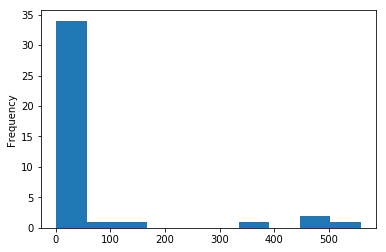

In [168]:
#distribution of numerator column
archive1.rating_numerator.value_counts().plot(kind='hist');

In [169]:
#dog names
archive1.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja',
       'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose',
       'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra',
       'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn',
       'Boomer', 'Cody', 'Rumble', 'Clifford', 'quite', 'Dewey', 'Scout',
       'Gizmo', 'Cooper', 'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy',
       'Meatball', 'Paisley', 'Albus', 'Neptune', '

In [170]:
#lowercased dog names
archive1[archive1.name.str.islower()==True].name

22      such      
56      a         
118     quite     
169     quite     
193     quite     
335     not       
369     one       
542     incredibly
649     a         
682     mad       
759     an        
773     very      
801     a         
819     very      
822     just      
852     my        
924     one       
988     not       
992     his       
993     one       
1002    a         
1004    a         
1017    a         
1025    an        
1031    very      
1040    actually  
1049    a         
1063    just      
1071    getting   
1095    mad       
       ...        
2191    a         
2198    a         
2204    an        
2211    a         
2212    the       
2218    a         
2222    a         
2235    a         
2249    a         
2255    a         
2264    a         
2273    a         
2287    a         
2304    a         
2311    a         
2314    a         
2326    quite     
2327    a         
2333    an        
2334    a         
2335    an        
2345    the 

In [171]:
#show a particular text entry
archive1.loc[9,'text']

'This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A'

In [172]:
images1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [173]:
images1.duplicated().any()

False

In [174]:
images1.p1.unique()

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher', 'Bernese_mountain_dog',
       'box_turtle', 'chow', 'shopping_cart', 'miniature_poodle',
       'golden_retriever', 'Gordon_setter', 'Walker_hound', 'pug',
       'bloodhound', 'Lhasa', 'English_setter', 'hen', 'desktop_computer',
       'Italian_greyhound', 'Maltese_dog', 'three-toed_sloth', 'ox',
       'malamute', 'guinea_pig', 'soft-coated_wheaten_terrier',
       'Chihuahua', 'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'Blenheim_spaniel', 'Pembroke', 'llama', 'Chesapeake_Bay_retriever',
       'curly-coated_retriever', 'dalmatian', 'Ibizan_hound',
       'Border_collie', 'Labrador_retriever', 'seat_belt', 'snail',
       'miniature_schnauzer', 'Airedale', 'triceratops', 'swab', 'hay',
       'hyena', 'jigsaw_puzzle', 'West_Highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'Rottweiler',
       'Siberian_husky', 'teddy', 

In [175]:
images1.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                     89 
Chihuahua                    83 
pug                          57 
chow                         44 
Samoyed                      43 
toy_poodle                   39 
Pomeranian                   38 
malamute                     30 
cocker_spaniel               30 
French_bulldog               26 
miniature_pinscher           23 
Chesapeake_Bay_retriever     23 
seat_belt                    22 
Siberian_husky               20 
Staffordshire_bullterrier    20 
German_shepherd              20 
web_site                     19 
Cardigan                     19 
Eskimo_dog                   18 
teddy                        18 
Shetland_sheepdog            18 
beagle                       18 
Maltese_dog                  18 
Shih-Tzu                     17 
Rottweiler                   17 
Lakeland_terrier             17 
Italian_greyhound            16 
kuvasz                       16 
          

In [176]:
images1.p2.unique()

array(['collie', 'miniature_pinscher', 'malinois', 'redbone', 'Rottweiler',
       'English_springer', 'mud_turtle', 'Tibetan_mastiff',
       'shopping_basket', 'komondor', 'Yorkshire_terrier',
       'English_foxhound', 'bull_mastiff', 'German_shepherd', 'Shih-Tzu',
       'Newfoundland', 'cock', 'desk', 'toy_terrier', 'toy_poodle',
       'otter', 'Chesapeake_Bay_retriever', 'Siberian_husky', 'skunk',
       'Afghan_hound', 'bloodhound', 'barracouta', 'papillon',
       'cocker_spaniel', 'chow', 'Irish_terrier', 'chain_saw', 'beagle',
       'giant_schnauzer', 'Labrador_retriever', 'Pembroke', 'Chihuahua',
       'Weimaraner', 'slug', 'Brittany_spaniel', 'standard_schnauzer',
       'teddy', 'armadillo', 'African_hunting_dog', 'vizsla', 'doormat',
       'pug', 'Italian_greyhound', 'Samoyed', 'Pomeranian',
       'miniature_poodle', 'Lakeland_terrier', 'Irish_setter', 'swab',
       'malamute', 'bath_towel', 'Border_collie', 'Leonberg', 'drake',
       'French_bulldog', 'ice_bear', 

In [177]:
images1.p2.unique()

array(['collie', 'miniature_pinscher', 'malinois', 'redbone', 'Rottweiler',
       'English_springer', 'mud_turtle', 'Tibetan_mastiff',
       'shopping_basket', 'komondor', 'Yorkshire_terrier',
       'English_foxhound', 'bull_mastiff', 'German_shepherd', 'Shih-Tzu',
       'Newfoundland', 'cock', 'desk', 'toy_terrier', 'toy_poodle',
       'otter', 'Chesapeake_Bay_retriever', 'Siberian_husky', 'skunk',
       'Afghan_hound', 'bloodhound', 'barracouta', 'papillon',
       'cocker_spaniel', 'chow', 'Irish_terrier', 'chain_saw', 'beagle',
       'giant_schnauzer', 'Labrador_retriever', 'Pembroke', 'Chihuahua',
       'Weimaraner', 'slug', 'Brittany_spaniel', 'standard_schnauzer',
       'teddy', 'armadillo', 'African_hunting_dog', 'vizsla', 'doormat',
       'pug', 'Italian_greyhound', 'Samoyed', 'Pomeranian',
       'miniature_poodle', 'Lakeland_terrier', 'Irish_setter', 'swab',
       'malamute', 'bath_towel', 'Border_collie', 'Leonberg', 'drake',
       'French_bulldog', 'ice_bear', 

In [178]:
images1.p3.unique()

array(['Shetland_sheepdog', 'Rhodesian_ridgeback', 'bloodhound',
       'miniature_pinscher', 'Doberman', 'Greater_Swiss_Mountain_dog',
       'terrapin', 'fur_coat', 'golden_retriever',
       'soft-coated_wheaten_terrier', 'Labrador_retriever', 'Pekinese',
       'Ibizan_hound', 'French_bulldog', 'malinois', 'Dandie_Dinmont',
       'borzoi', 'partridge', 'bookcase', 'basenji', 'miniature_poodle',
       'great_grey_owl', 'groenendael', 'Eskimo_dog', 'hamster', 'briard',
       'papillon', 'flat-coated_retriever', 'gar', 'Chihuahua', 'Shih-Tzu',
       'Pomeranian', 'dingo', 'power_drill', 'Saluki', 'Great_Pyrenees',
       'West_Highland_white_terrier', 'collie', 'toy_poodle', 'vizsla',
       'acorn', 'giant_schnauzer', 'teddy', 'common_iguana', 'wig',
       'water_buffalo', 'coyote', 'seat_belt', 'kelpie', 'space_heater',
       'Brabancon_griffon', 'standard_poodle', 'beagle',
       'Irish_water_spaniel', 'bluetick', 'Weimaraner',
       'Chesapeake_Bay_retriever', 'toilet_tiss

In [179]:
images1.p3.value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
beagle                            31
cocker_spaniel                    31
Pekinese                          29
toy_poodle                        29
Pomeranian                        29
Pembroke                          27
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
pug                               23
Cardigan                          23
basenji                           21
toy_terrier                       20
bull_mastiff                      20
Siberian_husky                    19
Boston_bull                       17
Shetland_sheepdog                 17
d

In [180]:
tweets1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
favorite_count    2327 non-null int64
retweet_count     2327 non-null int64
tweet_id          2327 non-null int64
dtypes: int64(3)
memory usage: 54.6 KB


In [181]:
archive1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [182]:
images1.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [183]:
tweets1.describe()

,favorite_count,retweet_count,tweet_id
count,2327.000000,2327.000000,2.327000e+03
mean,7067.910185,2478.453803,7.417930e+17
std,10983.036734,4196.681392,6.820795e+16
min,0.000000,1.000000,6.660209e+17
25%,1227.000000,497.500000,6.781394e+17
50%,3055.000000,1152.000000,7.178418e+17
75%,8622.000000,2871.000000,7.986547e+17
max,145170.000000,70962.000000,8.924206e+17


### Quality issues
1. **archive**: Contains retweets and replies which are hidden duplicates
2. **archive**: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp has to be dropped
3. **archive**: Extraneous HTML Tags in source column and wrong datatype
4. **archive**: Extraneous HTTP links in text columns
5. **archive**: Astronomical values in numerator column
6. **archive**: Inconsistent rating denominators
7. **archive,images,tweets**: Lowercased column headers initials
8. **Archive**: Lowercased and illogical dog names
9. **Archive**: Wrong datatype for timestamp column 

### Tidiness issues
1. Unnecessary disaggregation for doggo,pupper,puppo and fluffer columns.

2. Unnecessary disaggregation for p1,p1_dog,p1_conf,p2,p2_dog,p2_conf,p3,p3_conf and p3_dog columns

3. One dataframe split into two (archive and tweets dataframes)


## Cleaning Data

In [184]:
#copies of the 3 dataframes
archive=archive1.copy()
images=images1.copy()
tweets=tweets1.copy()

### Quality Issue #1 & #2:

#### Define: 
- Remove retweets
- Normalize number of rows between the 3 dataframes
- Drop unneccessary columns

#### Code

In [185]:
#obtain the tweet ids for retweets
retweets=archive[archive.retweeted_status_id.notnull()].tweet_id
#filter out retweets from images datafame
itweet=images.query("tweet_id not in @retweets").tweet_id
#keep only parent tweet ids 
tweets=tweets.query("tweet_id in @itweet")
itweet2=tweets.tweet_id
#exclude tweet ids not present in tweets
archive=archive.query("tweet_id in @itweet2")
#exclude tweet ids not present in tweets
images=images.query("tweet_id in @itweet2")

In [186]:
#drop unnecessary columns
archive.drop(['in_reply_to_status_id','in_reply_to_user_id', 'retweeted_status_id'
                    , 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis =1 ,inplace = True)

#### Test

In [187]:
archive.shape

(1986, 12)

In [188]:
images.shape

(1986, 12)

In [189]:
tweets.shape

(1986, 3)

### Quality Issue #3:

#### Define

- Remove html tags from source column entries

#### Code

In [190]:
archive.source = archive.source.str.replace(r'<(?:a\b[^>]*>|/a>)', '')
#convert to a categorical varible
archive.source.astype("category")

0       Twitter for iPhone
1       Twitter for iPhone
2       Twitter for iPhone
3       Twitter for iPhone
4       Twitter for iPhone
5       Twitter for iPhone
6       Twitter for iPhone
7       Twitter for iPhone
8       Twitter for iPhone
9       Twitter for iPhone
10      Twitter for iPhone
11      Twitter for iPhone
12      Twitter for iPhone
13      Twitter for iPhone
14      Twitter for iPhone
15      Twitter for iPhone
16      Twitter for iPhone
17      Twitter for iPhone
18      Twitter for iPhone
20      Twitter for iPhone
21      Twitter for iPhone
22      Twitter for iPhone
23      Twitter for iPhone
24      Twitter for iPhone
25      Twitter for iPhone
26      Twitter for iPhone
27      Twitter for iPhone
28      Twitter for iPhone
29      Twitter for iPhone
31      Twitter for iPhone
               ...        
2326    Twitter for iPhone
2327    Twitter for iPhone
2328    Twitter for iPhone
2329    Twitter for iPhone
2330    Twitter for iPhone
2331    Twitter for iPhone
2

#### Test

In [191]:
archive.source.value_counts()

Twitter for iPhone    1948
Twitter Web Client    28  
TweetDeck             10  
Name: source, dtype: int64

### Quality Issue #4

#### Define

- Remove http from text column

#### Code

In [192]:
#convert to pandas series
archi=pd.Series(archive.text)
#remove http 
archi=archi.str[:-24]
#store changes in dataframe
archive.text=archi

#### Test

In [193]:
archive.text[1]

"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10"

### Quality Issue #5 and #6 

#### Define

- Replace denominator greater than 10
- Replace numerator values greater than 10

#### Code

In [194]:
archive.rating_denominator.value_counts()

10     1968
50     3   
80     2   
11     2   
170    1   
150    1   
130    1   
120    1   
110    1   
90     1   
70     1   
40     1   
20     1   
7      1   
2      1   
Name: rating_denominator, dtype: int64

Rating denominator should have a default value of 10.

In [195]:
#replace denominator greater than 10
archive.rating_denominator=archive.rating_denominator.replace([50,80,11,170,150,130,120,110,90,70,40,20,7,2],10)           

In [196]:
archive[archive.rating_numerator>14].rating_numerator


433     84  
516     24  
695     75  
763     27  
902     165 
979     1776
1120    204 
1202    50  
1228    99  
1254    80  
1274    45  
1351    60  
1433    44  
1634    143 
1635    121 
1712    26  
1779    144 
1843    88  
2074    420 
Name: rating_numerator, dtype: int64

In [197]:
#Reveal text section of numerator values greater than 10 for extraction
archive[archive.rating_numerator>14].text

433     The floofs have been released I repeat the floofs have been released. 84/70                                                                      
516     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t
695     This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10                                         
763     This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back        
902     Why does this never happen at my front door... 165/150                                                                                           
979     This is Atticus. He's quite simply America af. 1776/10                                                                                           
1120    Say hello to this unbelievably well behaved squad of doggos. 204/170

**Important**:If a dog tweet has a dog rating of 45/50 (see index 1250). It is obvious that from the text there are 5 dogs in that tweet. Since denominator values are always 10, the denominator rating for a single dog in that photo is 50/5dogs=10. In the same vein, the numerator rating for a single dog in the photo is 45/5dogs=9. Therefore the adjusted rating = 9/10.
For dogs with denominator ratings!= 10 and numerator value greater than 14, we simply have to find the number that divides the denominator and yields 10 and use the same number to divide the numerator.
For index 433, instead of 84/70, you'll have 12/10
For index 902, instead of 165/150, you'll have 11/10

Exceptions were made for indices 516, 979 and 2075

In [198]:
archive.rating_numerator.astype("float")

0       13.0
1       13.0
2       12.0
3       13.0
4       12.0
5       13.0
6       13.0
7       13.0
8       13.0
9       14.0
10      13.0
11      13.0
12      13.0
13      12.0
14      13.0
15      13.0
16      12.0
17      13.0
18      13.0
20      12.0
21      13.0
22      14.0
23      13.0
24      13.0
25      12.0
26      13.0
27      13.0
28      13.0
29      12.0
31      13.0
        ... 
2326    2.0 
2327    7.0 
2328    9.0 
2329    11.0
2330    6.0 
2331    8.0 
2332    10.0
2333    9.0 
2334    3.0 
2335    1.0 
2336    11.0
2337    10.0
2338    1.0 
2339    11.0
2340    8.0 
2341    9.0 
2342    6.0 
2343    10.0
2344    9.0 
2345    10.0
2346    8.0 
2347    9.0 
2348    10.0
2349    2.0 
2350    10.0
2351    5.0 
2352    6.0 
2353    9.0 
2354    7.0 
2355    8.0 
Name: rating_numerator, Length: 1986, dtype: float64

In [199]:
#replace original numerator values with readjusted values
archive.rating_numerator=archive.rating_numerator.replace([84,75,27,165,204,50,99,80,45,60,44,143,121,26,144,88],[12,9.75,11.27,11,12,10,11,10,9,12,11,11,11,11.26,12,11])

In [200]:
#replace irretrievable astronomical values with nan
archive.rating_numerator=archive.rating_numerator.replace([24,1776,420],np.nan)

#### Test

In [201]:
archive.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10,Phineas,None,None,None,None


### Quality Issue #7

#### Define

- Capitalize column headers initials in all datasets

#### Code

In [202]:
#capitalize column headers 
archive.columns=archive.columns.str.title()
images.columns=images.columns.str.title()
tweets.columns=tweets.columns.str.title()
#capitalize Id and Url
archive.rename(columns={"Expanded_Urls":"Expanded_URLs","Tweet_Id":"Tweet_ID"},inplace=True)
images.rename(columns={"Tweet_Id":"Tweet_ID","Jpg_Url":"JPG_URL"},inplace=True)
tweets.rename(columns={"Tweet_Id":"Tweet_ID"},inplace=True)

#### Test

In [203]:
archive.columns

Index(['Tweet_ID', 'Timestamp', 'Source', 'Text', 'Expanded_URLs',
       'Rating_Numerator', 'Rating_Denominator', 'Name', 'Doggo', 'Floofer',
       'Pupper', 'Puppo'],
      dtype='object')

In [204]:
images.columns

Index(['Tweet_ID', 'JPG_URL', 'Img_Num', 'P1', 'P1_Conf', 'P1_Dog', 'P2',
       'P2_Conf', 'P2_Dog', 'P3', 'P3_Conf', 'P3_Dog'],
      dtype='object')

In [205]:
tweets.columns

Index(['Favorite_Count', 'Retweet_Count', 'Tweet_ID'], dtype='object')

### Quality Issue #8

#### Define
- Obtain some dog names from text columns to replace illogical entries in name column
- Rename the irretrievable names as nan

#### Code  

In [206]:
#Scan through text column to look the correct dog names
archive[archive.Name.str.islower()==True].Text

22      I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy)                              
56      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow)       
169     We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10              
193     Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective
369     Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace                                                          
542     We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10               
649     Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest      

In [207]:
#Scan through trucated layer to retreive dog names
archive[archive.Name.str.islower()==True].Text.loc[1340:2161]

1340    Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper                              
1351    Here is a whole flock of puppers.  60/50 I'll take the lot                                                              
1361    This is a Butternut Cumberfloof. It's not windy they just look like that. 11/10 back at it again with the red socks     
1362    This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10                   
1368    This is a Wild Tuscan Poofwiggle. Careful not to startle. Rare tongue slip. One eye magical. 12/10 would def pet        
1382    "Pupper is a present to world. Here is a bow for pupper." 12/10 precious as hell                                        
1385    We only rate dogs. Pls stop sending in non-canines like this Mongolian grass snake. This is very frustrating. 11/10     
1435    Please stop sending in saber-toothed tigers. This is getting ridiculous. We only rate dog

In [208]:
#replace illogical names with recovered names
archive.at[22,'Name']="Roxy"
archive.at[56,'Name']="Puffie"
archive.at[369,'Name']="Grace"
archive.at[649,'Name']="Forrest"
archive.at[992,'Name']="Quizno"
archive.at[1853,'Name']="Wylie"
archive.at[1955,'Name']="Kip"
archive.at[2034,'Name']="Jacob"
archive.at[2066,'Name']="Rufus"
archive.at[2116,'Name']="Spork"
archive.at[2125,'Name']="Cherokee"
archive.at[2128,'Name']="Henry"
archive.at[2146,'Name']="Alphred"
archive.at[2161,'Name']="Alfredo"
archive.at[2191,'Name']="Leroi"
archive.at[2204,'Name']="Berta"
archive.at[2218,'Name']="Chuk"
archive.at[2235,'Name']="Alfonso"
archive.at[2249,'Name']="Cheryl"
archive.at[2255,'Name']="Jessica"
archive.at[2264,'Name']="Klint"
archive.at[2273,'Name']="Kohl"
archive.at[2287,'Name']="Daryl"
archive.at[2304,'Name']="Pepe"
archive.at[2311,'Name']="Octaviath"
archive.at[2314,'Name']="John"

In [209]:
#Reveal the irretrievable illogical dog names
archive[archive.Name.str.islower()==True].Name.unique()

array(['quite', 'incredibly', 'a', 'very', 'my', 'one', 'not', 'an',
       'just', 'getting', 'this', 'unacceptable', 'all', 'infuriating',
       'the', 'actually', 'by', 'officially', 'light', 'space'], dtype=object)

In [210]:
#Replace with nan
archive.Name=archive.Name.replace(['None','quite', 'incredibly', 'a', 'very', 'my', 'one', 'not', 'an',
       'just', 'getting', 'this', 'unacceptable', 'all', 'infuriating',
       'the', 'actually', 'by', 'officially', 'light', 'space'],np.nan)

#### Test

In [211]:
(archive.Name.str.islower()==True).all()

False

### Quality Issue #9

#### Define

- Convert Timestamp from string object to datetime object

#### Code

In [212]:
archive.Timestamp=archive.Timestamp.astype("datetime64[ns]")

#### Test

In [213]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 2355
Data columns (total 12 columns):
Tweet_ID              1986 non-null int64
Timestamp             1986 non-null datetime64[ns]
Source                1986 non-null object
Text                  1986 non-null object
Expanded_URLs         1986 non-null object
Rating_Numerator      1983 non-null float64
Rating_Denominator    1986 non-null int64
Name                  1369 non-null object
Doggo                 1986 non-null object
Floofer               1986 non-null object
Pupper                1986 non-null object
Puppo                 1986 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 281.7+ KB


### Tidiness Issue #1

#### Define

- Combine all 4 columns (doggo,floofer,pupper and puppo) for dog stages into column called 'Stage'
- Drop the 4 columns afterwards

#### Code

In [214]:
#replace None with nan in all 4 stages
archive.Doggo.replace("None",np.nan,inplace=True)
archive.Floofer.replace("None",np.nan,inplace=True)
archive.Pupper.replace("None",np.nan,inplace=True)
archive.Puppo.replace("None",np.nan,inplace=True)

In [215]:
#store dog stages in a list called stages
Stages=['Floofer','Doggo','Pupper','Puppo']
#create stage column with entries from the 4 stages and drop nan afterwards
archive['Stage']=archive[Stages].apply(lambda x: ', '.join(x.dropna().astype(str)),axis =1)
archive.Stage=archive.Stage.replace('', np.nan)
#drop all 4 stages
archive=archive.drop(columns=Stages, axis=1)


#### Test

In [216]:
archive.Stage.value_counts()

pupper            203
doggo             62 
puppo             22 
doggo, pupper     9  
floofer           7  
floofer, doggo    1  
doggo, puppo      1  
Name: Stage, dtype: int64

### Tidiness Issue #2

#### Define

- Reduce 9 columns('P1','P1_Conf','P1_Dog','P2','P2_Conf','P2_Dog','P3','P3_Conf','P3_Dog') into 3 columns (Confidence, Dog_Breed, Dog_Image)
- Drop the aforementioned 9 columns

#### Code

In [217]:
#Create lists for confidence,dog breed and dog image
Confidence=[]
Dog_Breed=[]
Dog_Image=[]

#Initialize the confidence for each 3 prediction and store their max in P_Max
P1c=0
P2c=0
P3c=0
P_Max=0

for index, row in images.iterrows():
    P1c=images.loc[index,'P1_Conf']
    P2c=images.loc[index,'P2_Conf']
    P3c=images.loc[index,'P3_Conf']
    #store the three 
    P_Max=max(P1c,P2c,P3c)
    #Append the maximum to Confidence
    Confidence.append(P_Max)
    # Appending criteria for Dog Breed and Dog Image
    if P_Max==P1c:
        Dog_Image.append(images.loc[index,'P1_Dog'])
        Dog_Breed.append(images.loc[index,'P1'])
    elif P_Max==P2c:
        Dog_Image.append(images.loc[index,'P2_Dog'])
        Dog_Breed.append(images.loc[index,'P2'])
    else:
        Dog_Image.append(images.loc[index,'P3_Dog'])
        Dog_Breed.append(images.loc[index,'P3'])

images['Confidence']=Confidence
images['Dog_Image']=Dog_Image
images['Dog_Breed']=Dog_Breed

In [218]:
#drop the other columns
images.drop(['P1','P1_Conf','P1_Dog','P2','P2_Conf','P2_Dog','P3','P3_Conf','P3_Dog'],axis=1,inplace=True)

In [219]:
#rename image num column
images.rename(columns={'Img_Num':'Image_Num'},inplace=True)
#convert image num to categorical
images.Image_Num= images.Image_Num.astype('category')

#### Test

In [220]:
images.head(3)

,Tweet_ID,JPG_URL,Image_Num,Confidence,Dog_Image,Dog_Breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,0.465074,True,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,0.506826,True,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,0.596461,True,German_shepherd


### Tidiness Issue #3

#### Define

Merge archives and tweets dataframes

#### Code

In [221]:
#merge archive and tweets
archive=pd.merge(archive, tweets, on=['Tweet_ID'], how='inner')

#### Test

In [222]:
archive.head(2)

,Tweet_ID,Timestamp,Source,Text,Expanded_URLs,Rating_Numerator,Rating_Denominator,Name,Stage,Favorite_Count,Retweet_Count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10,Phineas,NaN,33877,7034
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,NaN,29378,5309


## Storing Data

In [223]:
archive.to_csv('twitter_archive_master.csv',encoding='utf-8',index=False)

In [224]:
images.to_csv('Dog_Image_Predictions.csv',encoding='utf-8',index=False)

## Analyzing and Visualizing Data

### Insights:
1. What's the strength of the relationship between dog ratings, favourite counts and retweet counts on Twitter?
2. From Insights derived in Q1, construct a regression equation for strongly correlated variables
3. What percentage of the dog images did the neural network wrongly identify? 

**Question 1**: What's the strength of the relationship between dog ratings, favourite counts and retweet counts on Twitter?

In [225]:
#construct the Pearson's correlation matrix
archive[["Rating_Numerator","Favorite_Count","Retweet_Count"]].corr(method='pearson')

,Rating_Numerator,Favorite_Count,Retweet_Count
Rating_Numerator,1.000000,0.379712,0.286525
Favorite_Count,0.379712,1.000000,0.928405
Retweet_Count,0.286525,0.928405,1.000000


There is a high correlation between favorite count and retweet count on Twitter.

**Question 2**: From Insights derived in Q1, construct a regression equation for strongly correlated variables

In [226]:
from sklearn import preprocessing, svm
#import linear_model from scikit_learn
from sklearn.linear_model import LinearRegression
#Create linear regression object using the constructor
lm=LinearRegression()

In [227]:
#Define predictor and target variables
X=archive[['Favorite_Count']]
Y=archive['Retweet_Count']
#fit the model
lm.fit(X,Y)
#Obtain the slope and intercept
lm.coef_, lm.intercept_

(array([ 0.32834864]), -286.18885056452746)

The simple linear regression equation: 
    Retweets = 0.328Favorites - 286.189

**Question 3**: What percentage of the dog images did the neural network wrongly identify?

In [228]:
False_Predict=images[images.Dog_Image==False].shape[0]
True_Predict=images[images.Dog_Image==True].shape[0]
Total_Predict=images.shape[0]
print(False_Predict,True_Predict,Total_Predict )

517 1469 1986


In [229]:
Percent_False=(False_Predict/Total_Predict)*100
round(Percent_False,2)

26.03

517 images representing 26.03% of 1986 were falsely identified as not dogs by the neural network. While 1469 images were identified by the neural neural network as dog images.

### Visualization

Display the strongly correlated variables in a heatmap

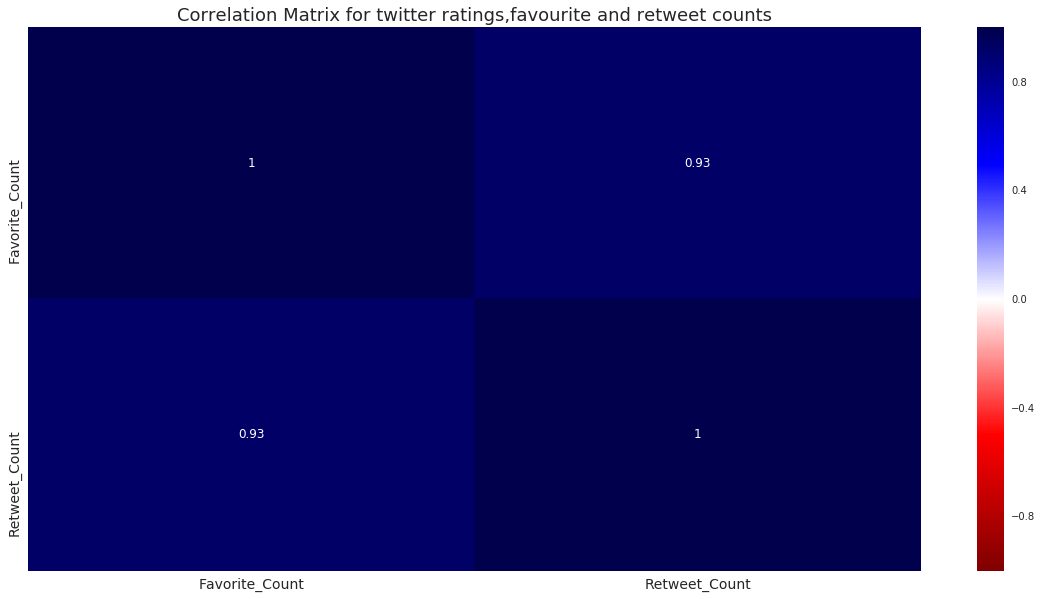

In [230]:
Relationship=archive[["Favorite_Count","Retweet_Count"]].corr(method='pearson')
plt.figure(figsize=(20,10))
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.heatmap(Relationship, cmap='seismic_r',annot=True,vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix for twitter ratings,favourite and retweet counts", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

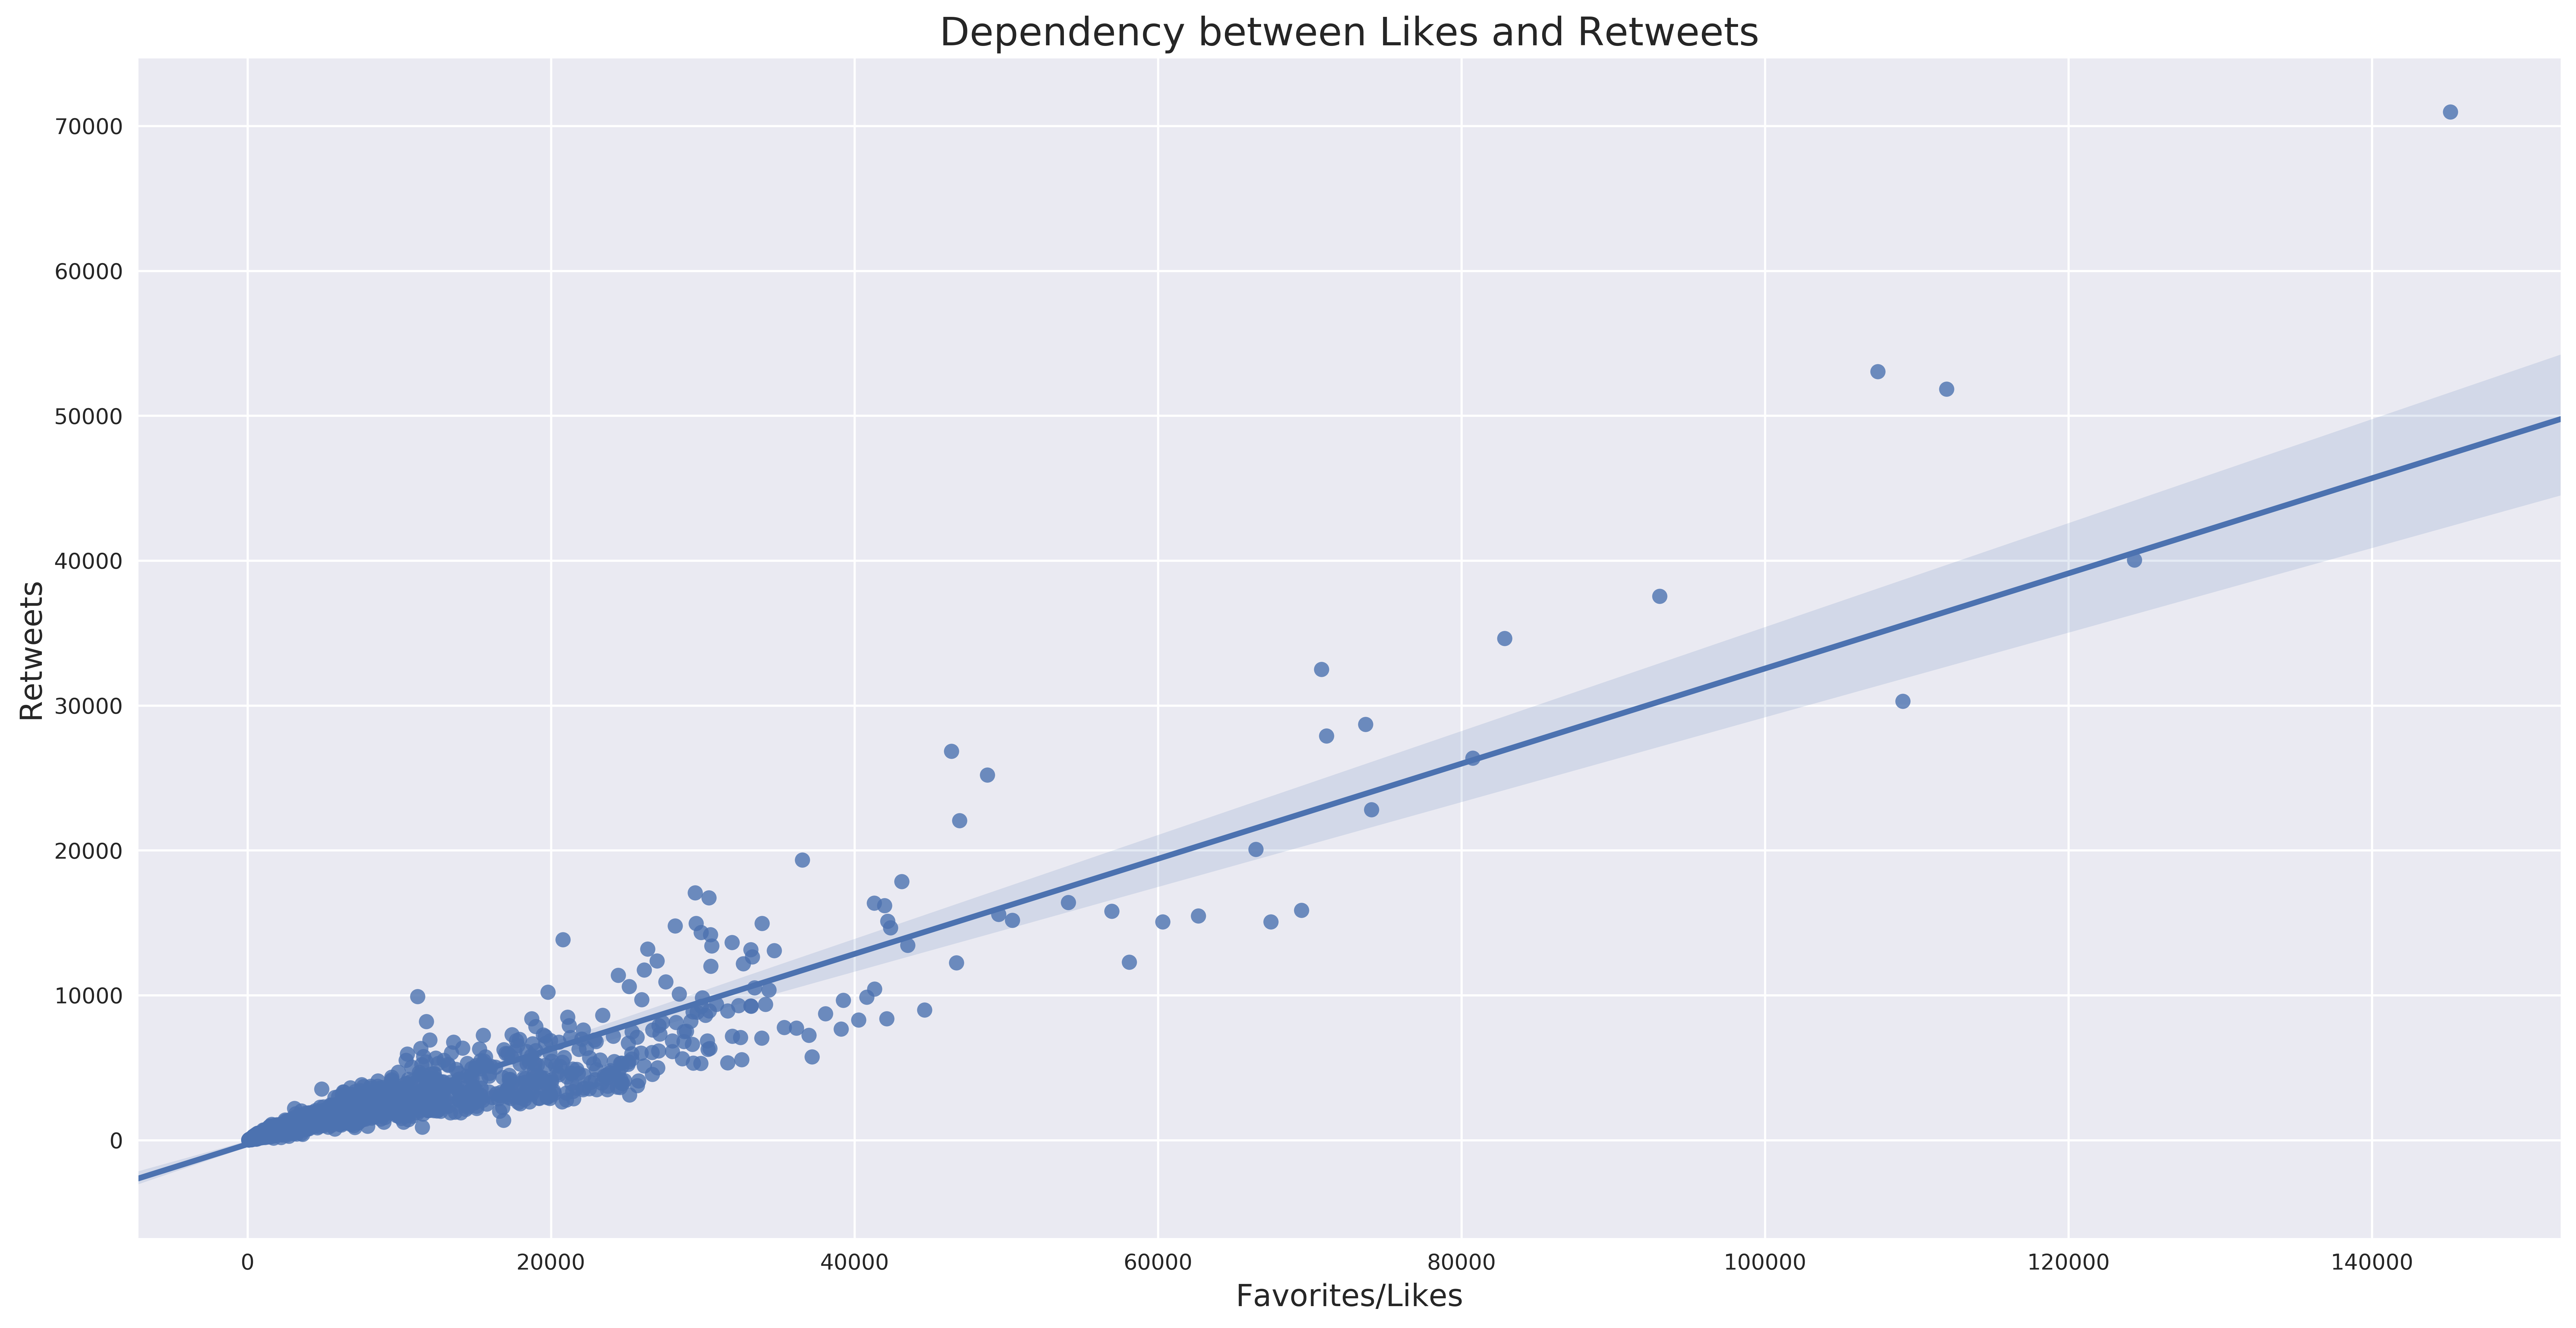

In [231]:
#Build regression plots
plt.figure(figsize=(20,10))
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.regplot(data=archive,x="Favorite_Count",y="Retweet_Count")
#set plot title
plt.title("Dependency between Likes and Retweets", fontsize=18)
#set x and y plot labels
plt.xlabel("Favorites/Likes", fontsize=14)
plt.ylabel("Retweets", fontsize=14);

## Limitations

The tweets for this analysis was pulled from 2015 to 2017. This might affect the currency quality dimension of all the analysis performed. Secondly, there is no singular definition for a clean dataset. Every data analyst has a preference with predetermined criteria.